In [49]:
from pathlib import Path
import os
import pandas as pd


def find_project_root(start: str | None = None) -> Path:
    start_path = Path(start or Path.cwd()).resolve()
    for p in [start_path, *start_path.parents]:
        if (p / ".git").exists():
            return p
    return start_path


PROJECT_ROOT = find_project_root()
os.chdir(PROJECT_ROOT)
print(f"cwd set to project root: {PROJECT_ROOT}")

cwd set to project root: /Users/xiaobaodawang/Research/replicate/LLM_Firm_code


In [51]:
import pandas as pd
import numpy as np
path = 'output/experiment_2/'
reps108 = pd.read_csv('experiments/alternatives/represents108.csv')
wins = []
for id in reps108['real_profile_id']:
    df = pd.read_csv(path + f'{id.replace(" ", "_")}_fixreal_altset108.csv')
    win = len((df[df['profile_id']==id]))
    wins.append(win)
df_sum = pd.DataFrame({'real_profile_id': reps108['real_profile_id'], 'wins': wins})
df_sum.sort_values('wins', ascending=False, inplace=True)
df_sum.reset_index(drop=True, inplace=True)
df_sum.reset_index(inplace=True)
df_sum.rename(columns={'index': 'rank'}, inplace=True)
df_sum['rank'] = df_sum['rank'] + 1
df_sum['win_rate'] = df_sum['wins'] / 108
df_sum = pd.merge(df_sum, reps108, on='real_profile_id', how='left')
df_sum[df_sum['real_profile_id'].isin(['iPhone 16','iPhone 16 Plus', 'iPhone 16 Pro', 'iPhone 16 Pro Max', 'iPhone 17', 'iPhone 17 Air', 'iPhone 17 Pro', 'iPhone 17 Pro Max'])]

,rank,real_profile_id,wins,win_rate,battery_life,screen_size,thickness,front_camera,rear_camera,focal_length,ultrawide,geekbench,ram,price
0,1,iPhone 16 Plus,107,0.990741,27,6.7,7.80,12,48,2,equipped,8208,8,999
1,2,iPhone 16 Pro,106,0.981481,27,6.3,8.25,12,48,5,equipped,8581,8,1099
2,3,iPhone 16 Pro Max,106,0.981481,33,6.9,8.25,12,48,5,equipped,8504,8,1199
3,4,iPhone 16,105,0.972222,22,6.1,7.80,12,48,2,equipped,8205,8,899
5,6,iPhone 17,101,0.935185,30,6.3,7.95,18,48,2,equipped,9191,8,799
14,15,iPhone 17 Pro,89,0.824074,33,6.3,8.75,18,48,8,equipped,9737,12,1099
26,27,iPhone 17 Pro Max,80,0.740741,39,6.9,8.75,18,48,8,equipped,9776,12,1199
73,74,iPhone 17 Air,36,0.333333,27,6.5,5.64,18,48,2,not equipped,9323,12,999


In [90]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import plotly.io as pio

features = [
    'battery_life', 'screen_size', 'thickness', 'front_camera', 'rear_camera',
    'focal_length', 'ultrawide', 'geekbench', 'ram', 'price'
]

real_profiles = [
    'iPhone 16', 'iPhone 16 Plus', 'iPhone 16 Pro', 'iPhone 16 Pro Max',
    'iPhone 17', 'iPhone 17 Air', 'iPhone 17 Pro', 'iPhone 17 Pro Max'
]

plot_df = df_sum.copy()
X = plot_df[features].apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.median(numeric_only=True)).fillna(0)
X_scaled = StandardScaler().fit_transform(X)
pcs = PCA(n_components=2, random_state=42).fit_transform(X_scaled)

plot_df['PC1'] = pcs[:, 0]
plot_df['PC2'] = pcs[:, 1]
plot_df['is_real'] = plot_df['real_profile_id'].isin(real_profiles)

others = plot_df[~plot_df['is_real']].copy().sort_values('win_rate')
real = plot_df[plot_df['is_real']].copy().sort_values('win_rate')

z_min = max(0, float(plot_df['win_rate'].min()) - 0.03)
z_max = 1.2

fig = go.Figure()

# Bottom projection (solid color, no gradient)
fig.add_trace(go.Scatter3d(
    x=others['PC1'],
    y=others['PC2'],
    z=[z_min] * len(others),
    mode='markers',
    marker=dict(size=3, color='rgba(31,119,180,0.22)', symbol='circle'),
    hoverinfo='skip',
    showlegend=False
))

# Generated profiles (blue circles)
fig.add_trace(go.Scatter3d(
    x=others['PC1'],
    y=others['PC2'],
    z=others['win_rate'],
    mode='markers',
    marker=dict(size=5, color='#1f77b4', symbol='circle', opacity=0.85),
    name='Generated profiles',
    text=others['real_profile_id'],
    customdata=others['rank'],
    hovertemplate='Profile: %{text}<br>Rank: %{customdata}<br>PC1: %{x:.2f}<br>PC2: %{y:.2f}<br>Win rate: %{z:.3f}<extra></extra>'
))

# Real profiles (red markers + label with rank)
fig.add_trace(go.Scatter3d(
    x=real['PC1'],
    y=real['PC2'],
    z=real['win_rate'],
    mode='markers+text',
    marker=dict(size=7, color='#ff2b2b', symbol='circle-open', opacity=1, line=dict(width=0)),
    text=[f"{n} ({int(r)})" for n, r in zip(real['real_profile_id'], real['rank'])],
    textposition='top center',
    textfont=dict(size=11, color='black'),
    name='Real profiles',
    hovertemplate='Profile: %{text}<br>PC1: %{x:.2f}<br>PC2: %{y:.2f}<br>Win rate: %{z:.3f}<extra></extra>'
))

fig.update_layout(
    title='Profiles in PCA Space (PC1-PC2) with Win Rate',
    width=1100,
    height=760,
    legend=dict(x=0.78, y=0.95, bgcolor='rgba(255,255,255,0.8)'),
    margin=dict(l=0, r=0, b=0, t=48),
    scene=dict(
        xaxis=dict(title='PC1', gridcolor='rgba(120,120,120,0.25)', zeroline=False),
        yaxis=dict(title='PC2', gridcolor='rgba(120,120,120,0.25)', zeroline=False),
        zaxis=dict(title='Win rate', range=[z_min, z_max], gridcolor='rgba(120,120,120,0.25)', zeroline=False),
        camera=dict(projection=dict(type='orthographic'))
    )
)

try:
    fig.show()
except ValueError as e:
    if 'nbformat>=4.2.0' in str(e):
        pio.renderers.default = 'browser'
        fig.show(renderer='browser')
    else:
        raise

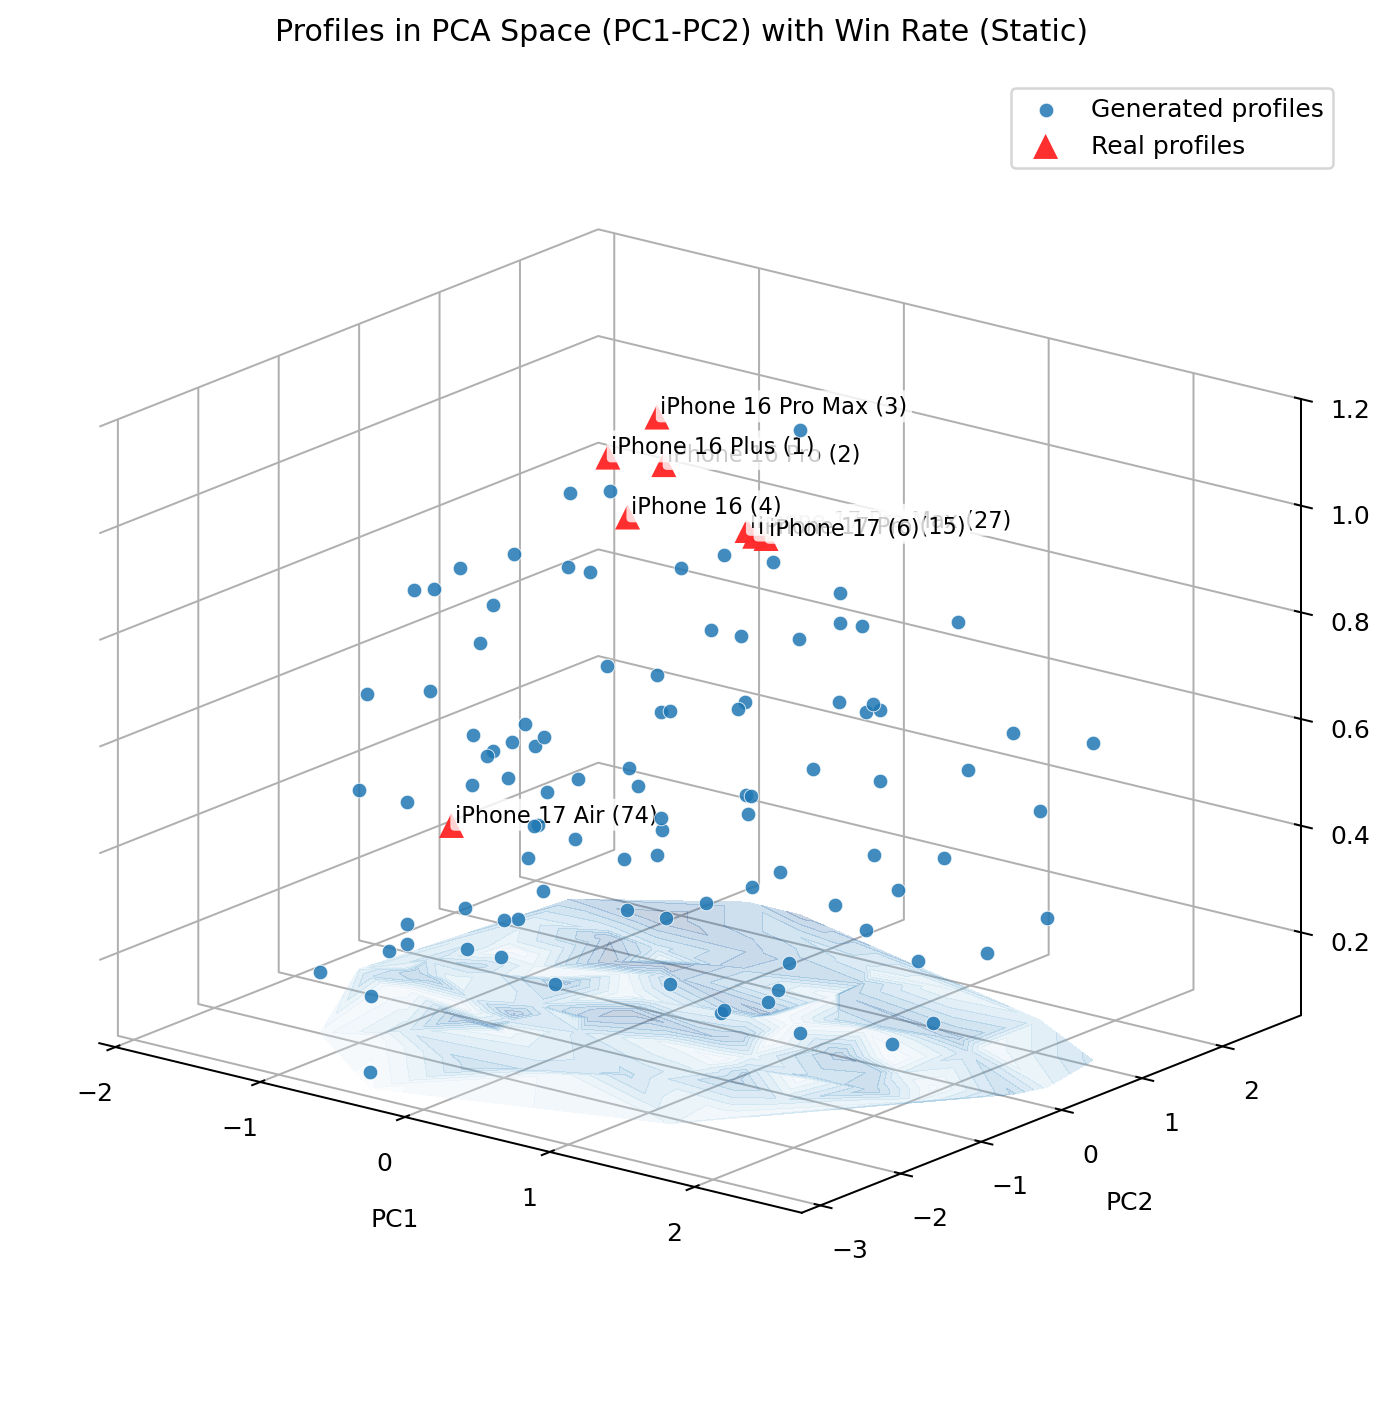

In [78]:
# Non-interactive 3D version (matplotlib)
import matplotlib.pyplot as plt

features = [
    'battery_life', 'screen_size', 'thickness', 'front_camera', 'rear_camera',
    'focal_length', 'ultrawide', 'geekbench', 'ram', 'price'
]

real_profiles = [
    'iPhone 16', 'iPhone 16 Plus', 'iPhone 16 Pro', 'iPhone 16 Pro Max',
    'iPhone 17', 'iPhone 17 Air', 'iPhone 17 Pro', 'iPhone 17 Pro Max'
]

plot_df = df_sum.copy()
X = plot_df[features].apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.median(numeric_only=True)).fillna(0)
X_scaled = StandardScaler().fit_transform(X)
pcs = PCA(n_components=2, random_state=42).fit_transform(X_scaled)

plot_df['PC1'] = pcs[:, 0]
plot_df['PC2'] = pcs[:, 1]
plot_df['is_real'] = plot_df['real_profile_id'].isin(real_profiles)

others = plot_df[~plot_df['is_real']].copy().sort_values('win_rate')
real = plot_df[plot_df['is_real']].copy().sort_values('win_rate')

fig = plt.figure(figsize=(10.5, 8), dpi=180)
ax = fig.add_subplot(111, projection='3d')

ax.set_proj_type('ortho')
ax.set_box_aspect((1.1, 1.0, 0.8))
ax.xaxis.set_pane_color((1, 1, 1, 1))
ax.yaxis.set_pane_color((1, 1, 1, 1))
ax.zaxis.set_pane_color((1, 1, 1, 1))
ax.grid(True, alpha=0.25)

z_min = max(0, float(plot_df['win_rate'].min()) - 0.03)
z_max = 1.2
ax.set_zlim(z_min, z_max)

# Bottom projection
ax.tricontourf(
    plot_df['PC1'], plot_df['PC2'], plot_df['win_rate'],
    zdir='z', offset=z_min, levels=10, cmap='Blues', alpha=0.22
)

ax.scatter(
    others['PC1'], others['PC2'], others['win_rate'],
    c='#1f77b4', marker='o', s=34, alpha=0.85,
    edgecolors='white', linewidths=0.35, depthshade=False,
    label='Generated profiles'
)

ax.scatter(
    real['PC1'], real['PC2'], real['win_rate'],
    c='#ff2b2b', marker='^', s=100, alpha=0.98,
    edgecolors='none', linewidths=0, depthshade=False,
    label='Real profiles'
)

for _, r in real.iterrows():
    ax.text(
        r['PC1'] + 0.015,
        r['PC2'] + 0.015,
        r['win_rate'] + 0.008,
        f"{r['real_profile_id']} ({int(r['rank'])})",
        fontsize=9,
        color='black',
        bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='none', alpha=0.8)
    )

ax.set_xlabel('PC1', labelpad=10)
ax.set_ylabel('PC2', labelpad=10)
ax.set_zlabel('Win rate', labelpad=8)
ax.set_title('Profiles in PCA Space (PC1-PC2) with Win Rate (Static)', pad=14)
ax.view_init(elev=18, azim=-52)
ax.legend(loc='upper right', frameon=True)

plt.tight_layout()
plt.show()

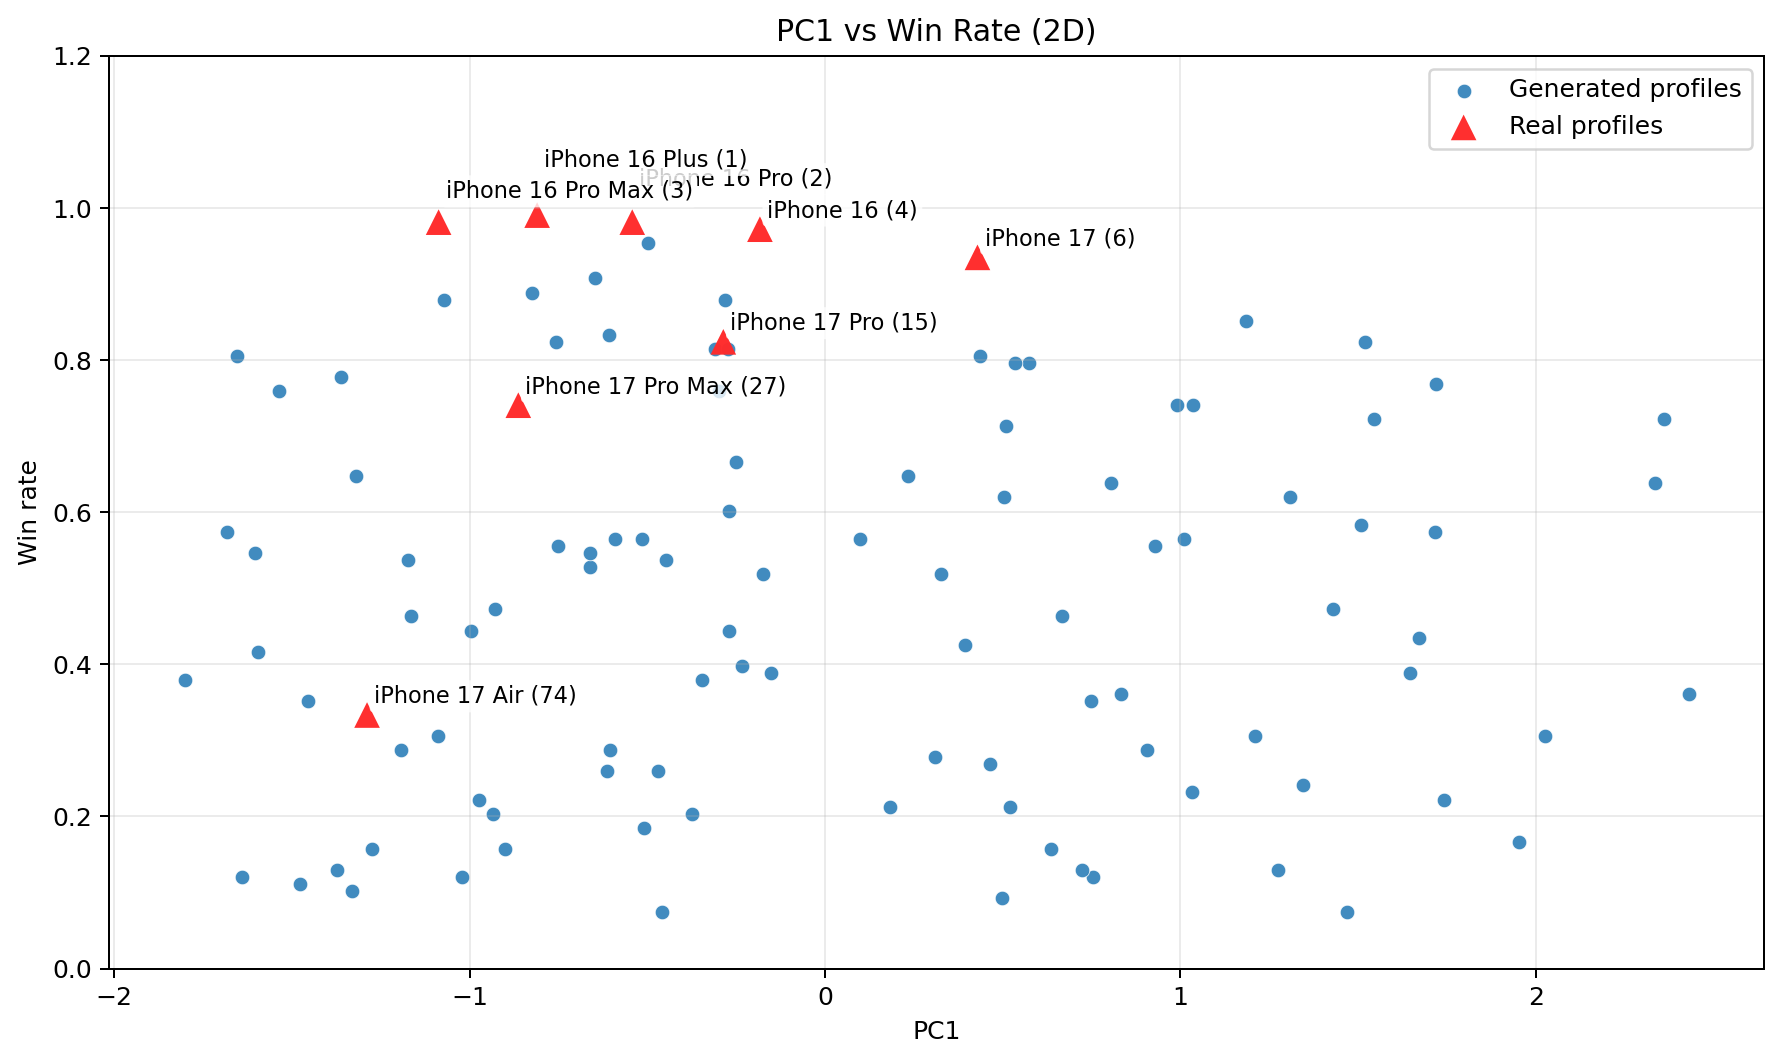

In [89]:
# 2D version: x = PC1, y = win rate
import matplotlib.pyplot as plt

features = [
    'battery_life', 'screen_size', 'thickness', 'front_camera', 'rear_camera',
    'focal_length', 'ultrawide', 'geekbench', 'ram', 'price'
]

real_profiles = [
    'iPhone 16', 'iPhone 16 Plus', 'iPhone 16 Pro', 'iPhone 16 Pro Max',
    'iPhone 17', 'iPhone 17 Air', 'iPhone 17 Pro', 'iPhone 17 Pro Max'
]

plot_df = df_sum.copy()
X = plot_df[features].apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.median(numeric_only=True)).fillna(0)
X_scaled = StandardScaler().fit_transform(X)
pcs = PCA(n_components=2, random_state=42).fit_transform(X_scaled)

plot_df['PC1'] = pcs[:, 0]
plot_df['is_real'] = plot_df['real_profile_id'].isin(real_profiles)

others = plot_df[~plot_df['is_real']].copy().sort_values('win_rate')
real = plot_df[plot_df['is_real']].copy().sort_values('win_rate')

plt.figure(figsize=(10, 6), dpi=180)

plt.scatter(
    others['PC1'], others['win_rate'],
    c='#1f77b4', s=34, alpha=0.85,
    edgecolors='white', linewidths=0.35,
    label='Generated profiles'
)

plt.scatter(
    real['PC1'], real['win_rate'],
    c='#ff2b2b', s=105, marker='^', alpha=0.98,
    edgecolors='none', linewidths=0,
    label='Real profiles'
)

for _, r in real.iterrows():
    plt.text(
        r['PC1'] + 0.02,
        r['win_rate'] + 0.016*(max(5-int(r['rank']), 1)),
        f"{r['real_profile_id']} ({int(r['rank'])})",
        fontsize=9,
        color='black',
        bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='none', alpha=0.8)
    )

plt.xlabel('PC1')
plt.ylabel('Win rate')
plt.ylim(0, 1.2)
plt.title('PC1 vs Win Rate (2D)')
plt.grid(alpha=0.25)
plt.legend(loc='upper right', frameon=True)
plt.tight_layout()
plt.show()